In [1]:
!pip install contractions
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import casual

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

     |████████████████████████████████| 327kB 7.5MB/s 
     |████████████████████████████████| 286kB 11.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85390 sha256=4dba25bea8d57036f559d82759ed3d2f6292b205b762dcfa7059aa790b379716
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [2]:
df = pd.read_csv('/content/drive/MyDrive/College/Semester 8/CSE 6240/tweets_clean.csv')

In [3]:
# Check the tweets that have follow or subscribe
(df['text'].str.contains('subscribe|follow')).sum()

104446

In [4]:
df.date = pd.to_datetime(df['date'], format = '%Y-%m-%d', errors='coerce')


In [5]:
df = df.dropna(subset=['date'])

In [6]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [7]:
df.groupby('year').sum()

,month,day
year,,
2017,1433424,1270898
2018,19670685,13175652
2019,83431762,182558310


In [8]:
df.year.value_counts().loc[lambda x : x>10000] 

2019    11226181
2018     2770654
2017      119452
Name: year, dtype: int64

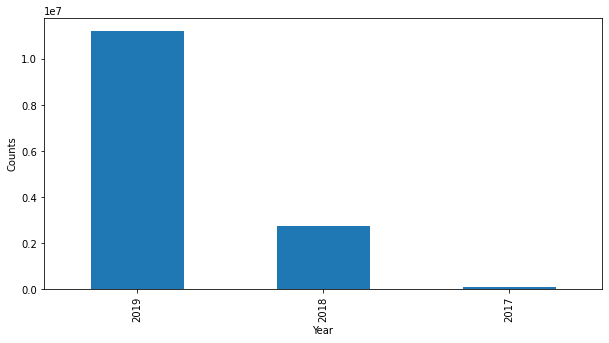

In [9]:
# Visualization of news article count per year

plt.figure(figsize=(10,5))
plt.xlabel("Year")
plt.ylabel("Counts")

df.year.value_counts().plot(kind='bar')
plt.show()

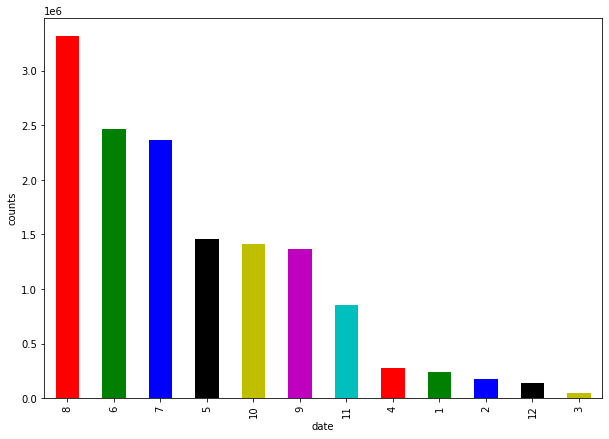

In [10]:
# Visualization of news publications names and article count in the dataset

import matplotlib.pyplot as plt

color_list = list('rgbkymc')  #red, green, blue, black, etc.
plt.figure(figsize=(10,7))

plt.xlabel("date")
plt.ylabel("counts")

df.month.value_counts().plot(kind='bar', color=color_list)

In [11]:
#expanding contractions
try:
  df['text1'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
except:
  df['text1'] = df['text']

In [12]:
def get_url(x):
  urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)
  
  if len(urls)==0:
    return ' '
  else:
    return urls

In [13]:
df = df.dropna(subset=['lang'])

In [14]:
df['url'] = df['text1'].apply(lambda x: get_url(x) )
df['url'] = [' '.join(map(str, l)) for l in df['url']]

In [15]:
#extracting the Tags to be able to clearer
def tag(x):
  hashtag = set(part[1:] for part in x.split() if part.startswith('#'))
  
  if len(hashtag)==0:
    return ' '
  else:
    return hashtag

df['tags'] = df['text1'].apply(lambda x: tag(x) )
df['tags'] = [' '.join(map(str, l)) for l in df['tags']]
df.sample(3)


,date,timestamp,text,lang,year,month,day,text1,url,tags
3817947,2019-05-11,2019-05-11 20:10:43+00,@Okaz_Sports @OKAZ_online https://t.co/9aSWP3w...,en,2019,5,11,@Okaz_Sports @OKAZ_online https://t.co/9aSWP3w...,https://t.co/9aSWP3woRm,Ebay Amazon Crypto auction best Facebook love ...
16070135,2019-09-27,2019-09-27 09:13:15+00,"Unique, modern, win-win trading strategies,\nd...",en,2019,9,27,"Unique, modern, win-win trading strategies,\nd...",https://t.co/DpJaSzjxB0,btc eth Walton
9707879,2019-07-06,2019-07-06 11:46:01+00,"Bitcoin, the currency backed by data! Be sure ...",en,2019,7,6,"Bitcoin, the currency backed by data! Be sure ...",https://t.co/5moRxxFbBk https://t.co/C4437LjvnS,bookcover authors


In [16]:
def prom(x):
  promoting = re.findall('subscribe | follow | promo', x)
  
  if len(promoting)==0:
    return ' '
  else:
    return promoting

df['promote'] = df['text1'].apply(lambda x: prom(x) )
df['promote'] = [' '.join(map(str, l)) for l in df['promote']]

In [17]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import regex as re
import contractions
# Install spaCy (run in terminal/prompt)
import sys

In [18]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 1.6MB 9.6MB/s eta 0:00:01
Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.0.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 12.8 MB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.4 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 9.1 MB 37.4 MB/s 
  

In [19]:
import nltk
nltk.download('stopwords')

def process(text):

    #Convert to lower case
    text = text.lower()
    #Convert www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    #Remove @username 
    text = re.sub('@[^\s]+',' ',text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    #trim
    text = text.strip('\'"')

    #remove punctuation
    for punctuation in string.punctuation: 
        text = text.replace(punctuation, ' ') 

    #words only
    text = ''.join([i for i in text if not i.isdigit()])

    #tokenize
    words = nltk.tokenize.casual_tokenize(text)

    #Remove stopwords
    stops = set(stopwords.words('english'))
    clean = [w for w in words if not w in stops]

    return ' '.join(clean)

df['clean'] = df['text1'].apply(lambda text: process(text))

df.sample(3, random_state = 3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,date,timestamp,text,lang,year,month,day,text1,url,tags,promote,clean
12387411,2019-08-06,2019-08-06 20:00:03+00,$XMR is now worth $92.29 (-0.08%) and 0.007881...,en,2019,8,6,$XMR is now worth $92.29 (-0.08%) and 0.007881...,https://t.co/UqSYMArARS,XMR,,xmr worth btc xmr ➡ ️
16771854,2019-10-13,2019-10-13 07:35:07+00,Hello #Author #publisher #writter\nCheck our m...,en,2019,10,13,Hello #Author #publisher #writter\nCheck our m...,https://t.co/QaJ0IeobnM,1013Gift fiverrgigs Author BiggBoss13 bitcoin ...,,hello author publisher writter check mt fiverr...
13948742,2019-08-28,2019-08-28 17:25:25+00,"Growing up, you believe banks provide a servic...",en,2019,8,28,"Growing up, you believe banks provide a servic...",,,,growing believe banks provide service people r...


In [20]:
df = df.reset_index()
df = df[['date', 'year','clean','url','tags','promote']]

In [21]:
df.to_csv('tweets_very_clean.csv')